# T_Matrix-Spectral_Analysis

In [62]:
# %%writefile T_matrix_spectral_analysis_tools.py
from __future__ import absolute_import
import os
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

# custom tools
from ismtools import SVD, log, stat_calc, make_df

def normality_val(matrix):
    """
    matrix: numpy 2d array
    RETURNS
    A measure of the "closeness to normality" of matrix as follows: ||M*M - MM*||_2
    where the norm is taken as the L2 norm for matrices and M is the matrix
    Normal matrices should score 0.
    """
    T = matrix
    T_trans = matrix.transpose()
    matrix_normality = np.linalg.norm(np.matrix(np.subtract(np.matmul(T,T_trans),np.matmul(T_trans,T))),'fro')
    return matrix_normality


def add_svd_stats(matrix, 
                  matrix_dict, 
                  stats, 
                  calc_SVD=False, 
                  log_spectrum=False,
                  normality=False
                 ):
    """
    Adds selected stats to the T_matrix_dict and returns dict with added stats
    matrix:        numpy array of the matrix to be processed to add to matrix_dict    
    matrix_dict:    dictionary with matrix to be added to processing matrix
    stats:          list statistics to store on the spectrum of the T_matrix
    log_spectrum:   Boolean if True (default) will run analysis on the log 
                    of the spectrum too.
    """
    # Load the actual matrix
    matrix_dict["matrix"] = matrix
    
    # Load Normality of the matrix
    if normality==True:
        matrix_dict["normality"] = normality_val(matrix)
    
    # Load the SVD 
    if calc_SVD==True:
        # Run SVD and add to sub keys
        U,s,Vh = SVD(matrix)
        matrix_dict["U_rotation"] = U
        matrix_dict["V_rotation_transpose"] = Vh
        matrix_dict["spectral_values"] = s

        # Conduct spectrum stats analysis
        for stat in stats:
            matrix_dict[stat] = stat_calc(stat, s, fro=None, acc=None)


        # Add log spectrum
        if log_spectrum==True:
            sl = log(s)
            matrix_dict["log_spectral_values"]= sl

            # Conduct log spectrum stats analysis
            for stat in stats:
                stat_of_log=stat+"_log"
                matrix_dict[stat_of_log] = stat_calc(stat, sl, fro=None, acc=None)
    
    return matrix_dict


def extract_T_matrix_dict(T_matrix_dir,
                          stats=['min','max','mean','median','std'],
                          calc_cov=True,
                          calc_inv=False,
                          calc_SVD=True,
                          log_spectrum=True,
                          normality=True,
                          verbose=0
                         ):
    """
    T_matrix_dir:  str location of the dir with the csv files for the translation matrices
    
    stats:         list of statistics to calculate on spectrum and log specturm if calc_SVD and 
                   log_spectrum are set to True respectively
                   
    calc_cov:      Boolean if default True, will process the covariance matrix and spectra in dict with key 'T_cov'
    calc_inv:      Boolean if default True, will process the matrix inverse and spectra in dict with key 'T_inv'

    calc_SVD:      Boolean if default True, will process the SVD of the T_matrix, and also calc_cov and calc_inv if 
                   they are set to true and add to the dict:
                   
                   U rotation numpy array 2d with key 'U_rotation'    
                   V* rotation numpy array 2d with key 'V_rotation_trans' 
                   Spectral values list with key 'spectral_values'

    
    log_spectrum:  Boolean if default True, adds to dict log of the spectral values list with key 'log_spectral_values'
    normality:     Boolean if default True, adds to dict the L2 norm of ||TT* - T*T|| with key 'normality'
    """
    # Create a list of items in T_matrix_dir
    T_matrix_dir_items = os.listdir(T_matrix_dir)

    # Loop through list of paths to process each matrix
    T_matrix_dict = {}
    for T_matrix_name in T_matrix_dir_items:

        # Create path name
        T_matrix_full_path = os.path.join(T_matrix_dir, T_matrix_name)

        # Extract language strings and extensions
        [T_matrix_lgs, T_matrix_ext] = T_matrix_name.split(".")
        T_matrix_lgs = T_matrix_lgs.rstrip("_T")

        # Filter for non csv extensions
        if T_matrix_ext != "csv":
            if verbose >= 1:
                print("Skipping %s item in %s: extension is not '.csv'" % (T_matrix_name,T_matrix_dir))

        else:
            # Load in csv as numpy array
            T_matrix = np.loadtxt(open(T_matrix_full_path), delimiter=",")

            ### Add matrices to T_matrix_dict under Lg1-Lg-2 key
            T_matrix_dict[T_matrix_lgs] = {}

            # Initialize raw T_matrix key
            T_matrix_dict[T_matrix_lgs]["T_matrix"] = {}
            
            # Load T_matrix and spectral analysis stats as configured into T_matrix sub dict
            T_matrix_dict[T_matrix_lgs]["T_matrix"] = add_svd_stats(matrix=T_matrix, 
                                                                    matrix_dict=T_matrix_dict[T_matrix_lgs]["T_matrix"], 
                                                                    stats=stats, 
                                                                    calc_SVD=calc_SVD, 
                                                                    log_spectrum=log_spectrum,
                                                                    normality=normality
                                                                   )
                                                                   
            
            # T_cov Covariance matrix TT^{T}
            if calc_cov==True:
                # calculate T_cov
                T_cov = np.dot(T_matrix,T_matrix.T)
                
                # Initialize T_cov key
                T_matrix_dict[T_matrix_lgs]["T_cov"] = {}
                
                # Load T_cov and spectral analysis stats as configured into T_cov sub dict
                T_matrix_dict[T_matrix_lgs]["T_cov"] = add_svd_stats(matrix=T_cov, 
                                                                     matrix_dict=T_matrix_dict[T_matrix_lgs]["T_cov"], 
                                                                     stats=stats, 
                                                                     calc_SVD=calc_SVD, 
                                                                     log_spectrum=log_spectrum,
                                                                     normality=normality
                                                                    )
                                                                    
                
                
            # T_inv Matrix Inverse T^{-1}
            if calc_inv==True:
                # calculate T_inv
                T_inv = np.linalg.inv(T_matrix)
                
                # Initialize T_inv key
                T_matrix_dict[T_matrix_lgs]["T_inv"] = {}
                
                # Load T_inv and spectral analysis stats as configured into T_inv sub dict
                T_matrix_dict[T_matrix_lgs]["T_inv"] = add_svd_stats(matrix=T_inv, 
                                                                     matrix_dict=T_matrix_dict[T_matrix_lgs]["T_inv"], 
                                                                     stats=stats, 
                                                                     calc_SVD=calc_SVD, 
                                                                     log_spectrum=log_spectrum,
                                                                     normality=normality
                                                                    )

    return T_matrix_dict



### Creating the heatmaps ###
def make_heatmap(T_matrix_dict, 
                 matrix_type,
                 stat, 
                 language_order= ['en','ru','de','es','fr','it', 'zh-CN'],
                 upper_matrix_type= False
                ):
    """
    Makes a heatmap for the specified stat and matrix_type from the T_matrix_dict
    
    matrix_dict:       dictionary with structure {'lg1_lg2':{"matrix_type":{stats:values}}}
    matrix_type:       string in {'T_matrix', 'T_cov', 'T_inv'} to build the heatmap from
    stat:              specific statistic to populate the heatmap
    language_order:    order of the rows and columns of the heatmap
    upper_matrix_type: Boolean or string, default False  
                       If False, all values will be filled in with stats from matrix_type.
                       If str in {'T_matrix', 'T_cov', 'T_inv'} upper matrix will be filled 
                       with stats from that matrix type
    """
    # Initialize the heatmap df with 0s
    df = make_df(language_order, language_order)
    
    # Loop through the language combos (or upper right combos)
    for i in range(len(language_order)):
        for j in range(len(language_order)):
            lg1 = language_order[i]
            lg2 = language_order[j]
            
            # Make language translation key from languages
            lg_key = str(lg1)+"_"+str(lg2)
            if lg_key not in T_matrix_dict.keys():
                print("Skipping %s: translation stats not available" % lg_key)
            
            # Pull value
            value = T_matrix_dict[lg_key][matrix_type][stat]
            
            # Adjust upper vals if configured
            if upper_matrix_type==False:
                upper_value = value
            else:
                upper_value = T_matrix_dict[lg_key][upper_matrix_type][stat]
            
            # Update value based on upper tri config
            if j<=i:                
                df.set_value(lg1,lg2,value)
            else:
                df.set_value(lg1,lg2,upper_value)
    return df

def plot_heatmaps(T_matrix_dict,
                  plotted_stats,
                  display_opt="cols",
                  matrix_types=["T_matrix"],
                  low_c=10,
                  high_c=130,
                  sep_num=50,
                  figuresize=[20,16]
                 ):
    """
    Plots Heatmaps from the T_matrix_dict generated by extract_T_matrix_dict
    
    T_matrix_dict:  dictionary containing translation matrices, and spectral analysis of them
    plotted_stats:   list of generated point spectral analysis statistics to be plotted
    display_opt:    str in {"cols","num"} if "cols" (default) heatmaps with colors generated
    matrix_types:    List subset of ["T_matrix","T_cov","T_inv"] if "T_inv" only upper triangle 
                    is plotted with T_matrix
    low_c:          num, coolest color spectrum number for heatmap
    high_c:         num, warmest color spectrum number for heatmap
    sep_num:        num, number of separators to use for heatmap
    """

    heatmaps={}
    for matrix_type in matrix_types:
        matrix_type_hmaps = {}
        
        # Initialize matrix_type plotting arguments
        upper_matrix_type = False
        matrix_type_used = matrix_type

        # plot only upper triangle with T_inv
        if matrix_type=="T_inv":
            matrix_type_used = "T_matrix"
            upper_matrix_type = "T_inv"
            
        for stat in plotted_stats:
            heatmap = make_heatmap(T_matrix_dict=T_matrix_dict, 
                                   matrix_type=matrix_type_used,
                                   stat=stat, 
                                   language_order= ['en','ru','de','es','fr','it', 'zh-CN'],
                                   upper_matrix_type=upper_matrix_type
                                  )
            
            # Set title
            if matrix_type=="T_matrix":
                title = "%s of the translation matrix spectrum" % stat
            
            elif matrix_type=="T_cov":
                title = "%s of the translation covariance matrix spectrum" % stat
            
            elif matrix_type=="T_inv":
                title = "%s of the translation matrix spectrum with inverse" % stat
                


            if display_opt=="cols":

                # Adjust colmap direction based on heatmap
                mean_diag = np.diag(heatmap).mean()
                hm_mean = np.array(heatmap).mean()

                if mean_diag>=hm_mean:
                    colmap = sns.diverging_palette(low_c, high_c, sep=sep_num, as_cmap=True)
                else:
                    colmap = sns.diverging_palette(high_c, low_c, sep=sep_num, as_cmap=True)
                
                # figure sizing
                plt.figure(figsize=(figuresize[0],figuresize[1]))
                hm = sns.heatmap(heatmap,cmap=colmap)
                #sns.plotting_context(font_scale=5)
                #title = hm.set_title(title)
                
                # Plot
                print(title)
                plt.show()
                hm
            else:
                print(title)
                display(heatmap)
            matrix_type_hmaps[stat] = heatmap

        # Add dict for that matrix type to full heatmap dict
        heatmaps[matrix_type]=matrix_type_hmaps
    
    return heatmaps

min of the translation matrix spectrum


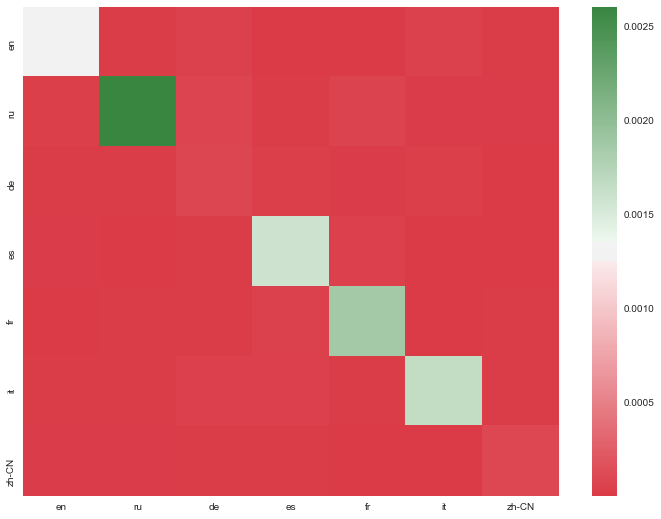

max of the translation matrix spectrum


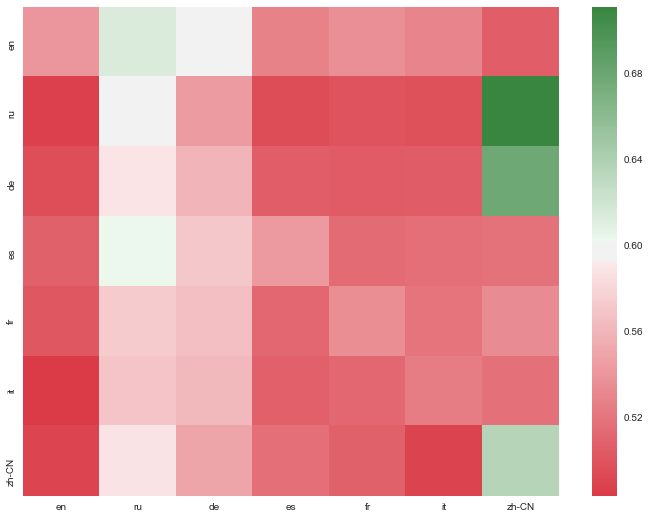

mean of the translation matrix spectrum


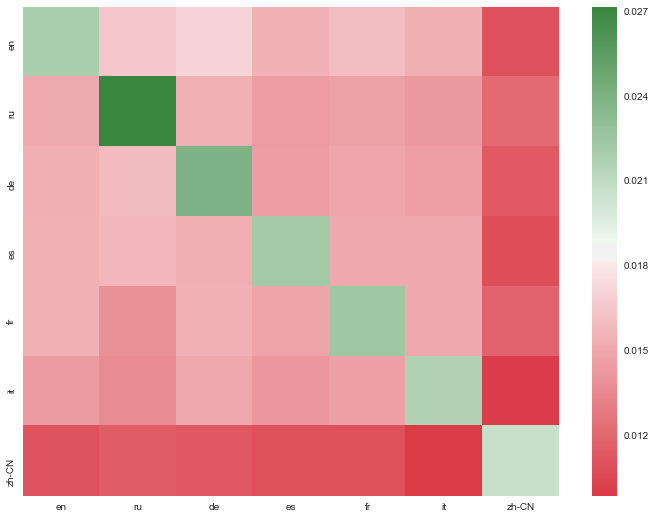

median of the translation matrix spectrum


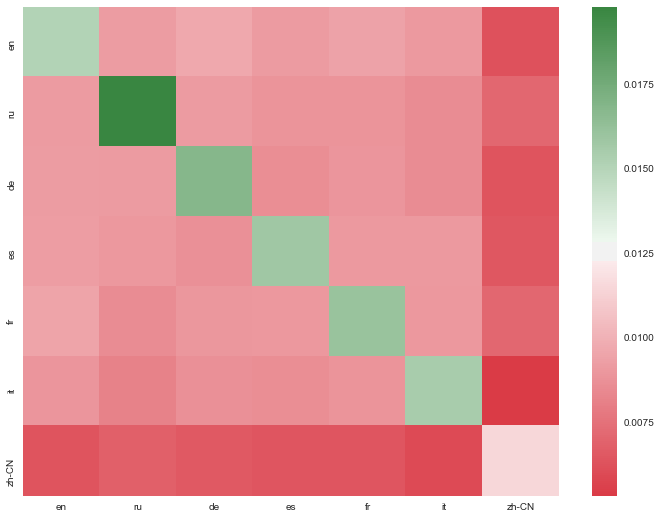

std of the translation matrix spectrum


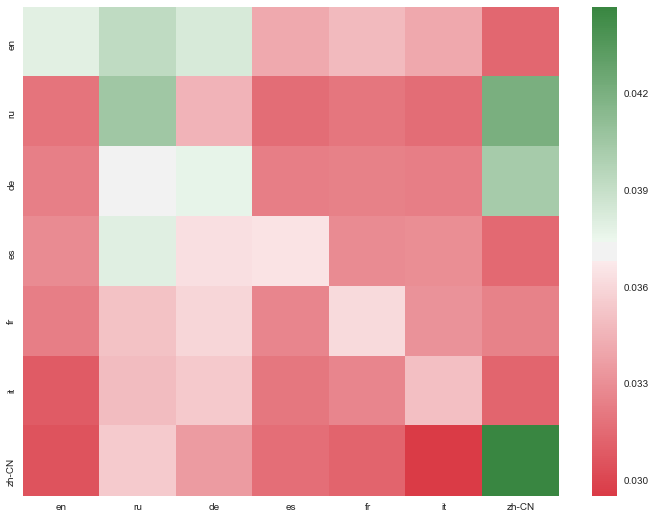

min_log of the translation matrix spectrum


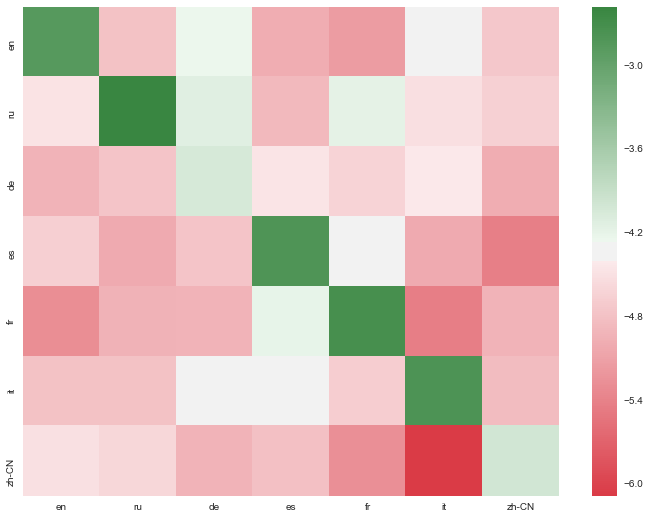

max_log of the translation matrix spectrum


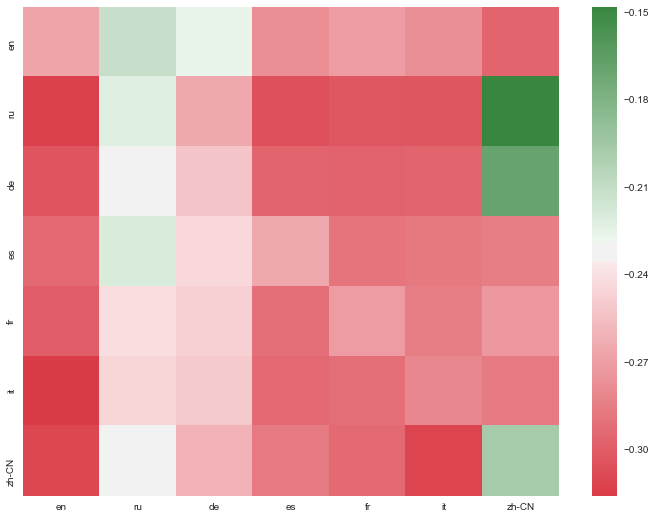

mean_log of the translation matrix spectrum


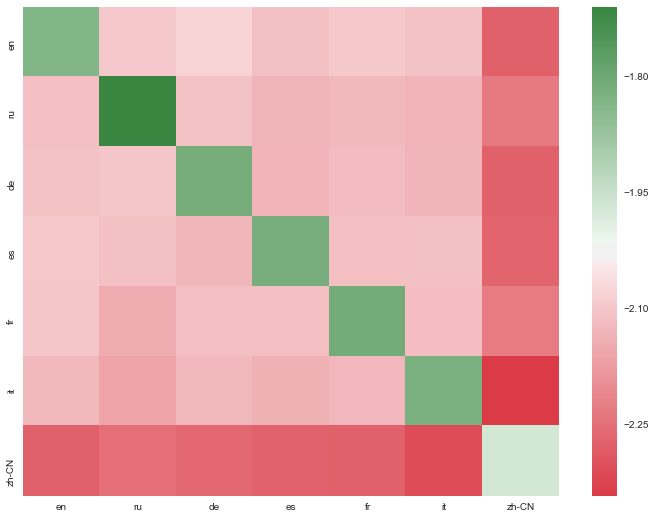

median_log of the translation matrix spectrum


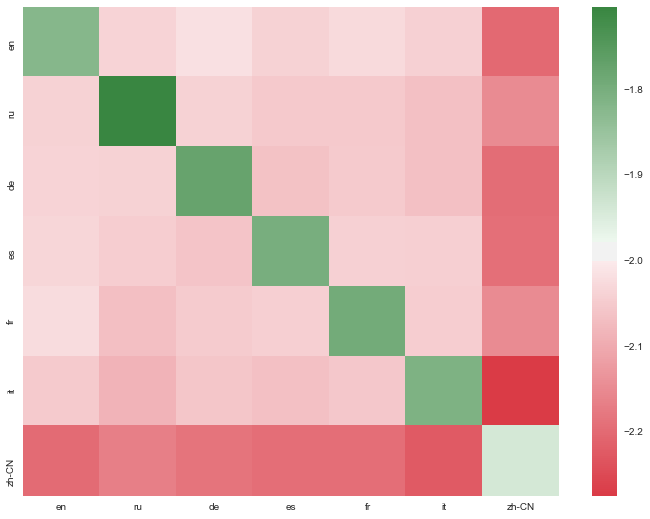

std_log of the translation matrix spectrum


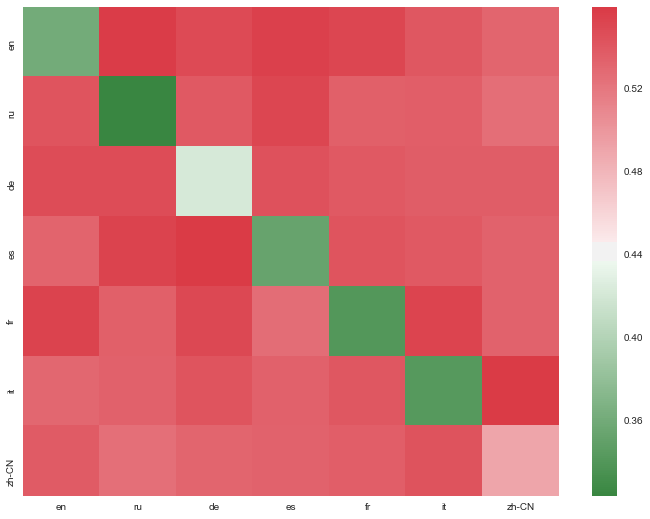

min of the translation covariance matrix spectrum


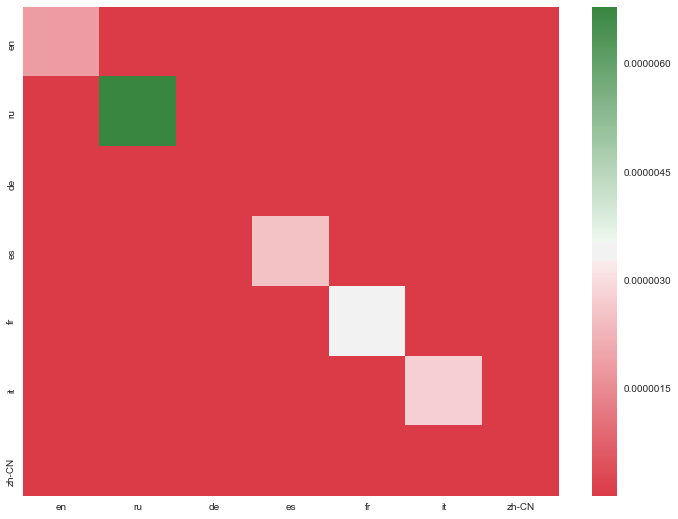

max of the translation covariance matrix spectrum


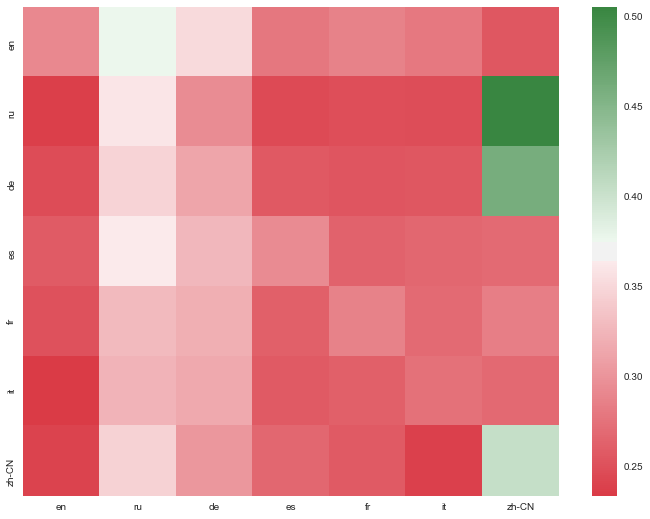

mean of the translation covariance matrix spectrum


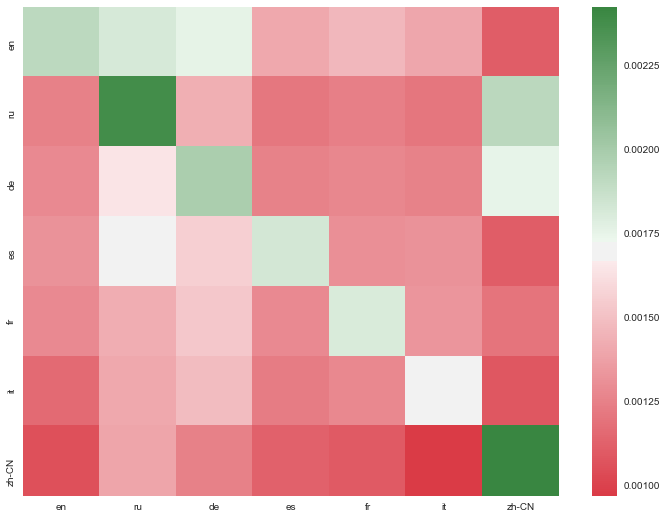

median of the translation covariance matrix spectrum


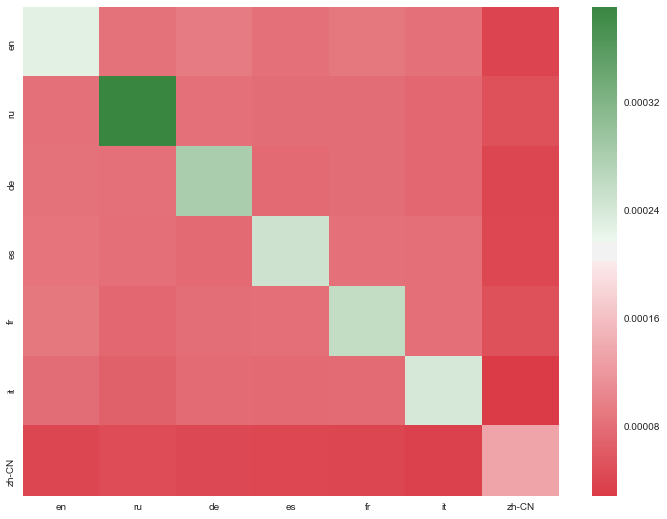

std of the translation covariance matrix spectrum


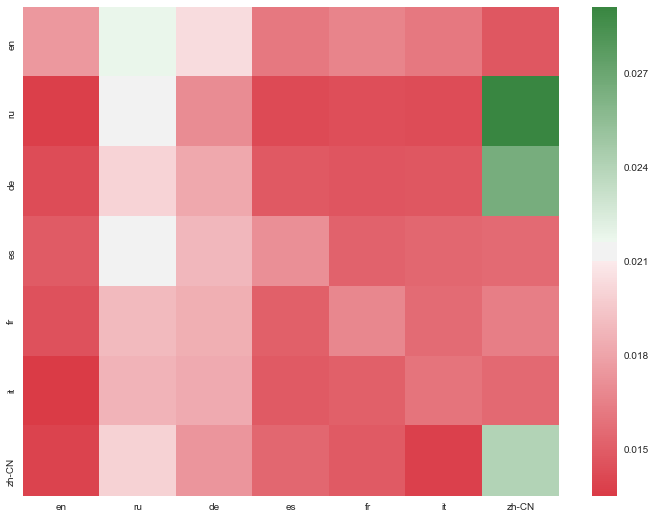

min_log of the translation covariance matrix spectrum


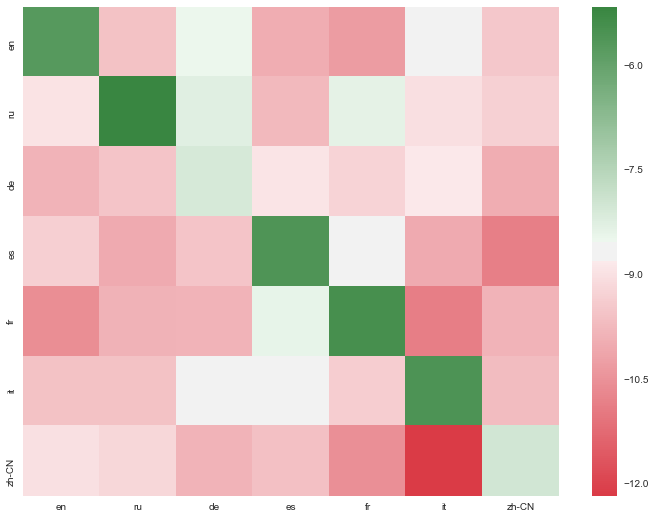

max_log of the translation covariance matrix spectrum


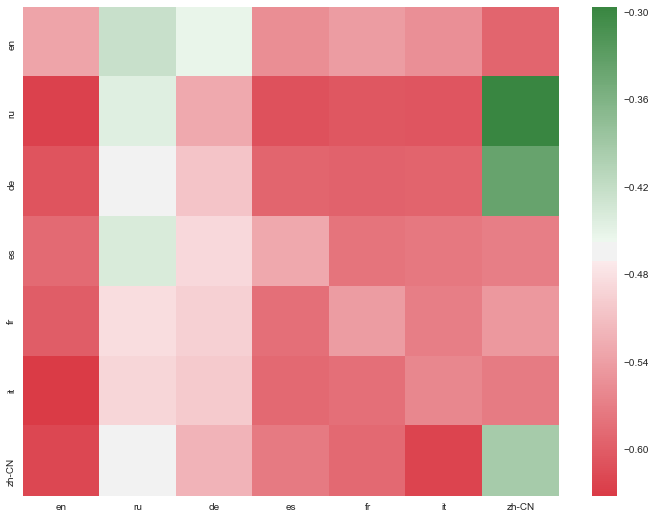

mean_log of the translation covariance matrix spectrum


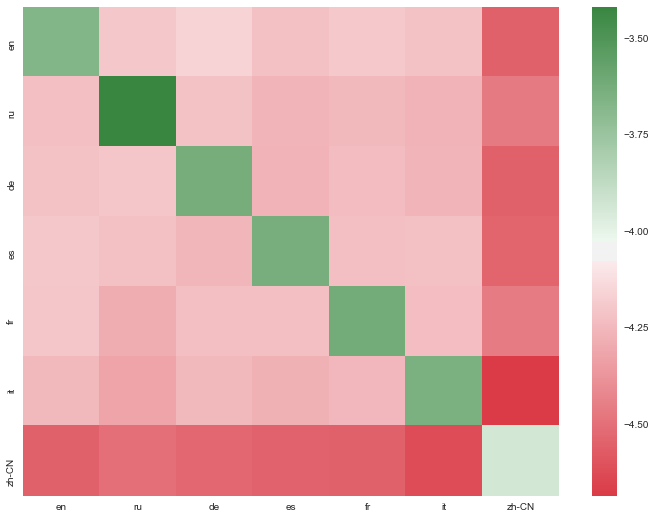

median_log of the translation covariance matrix spectrum


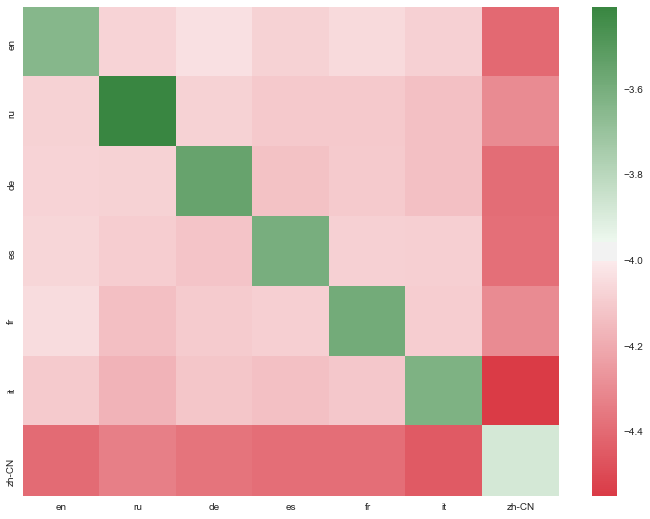

std_log of the translation covariance matrix spectrum


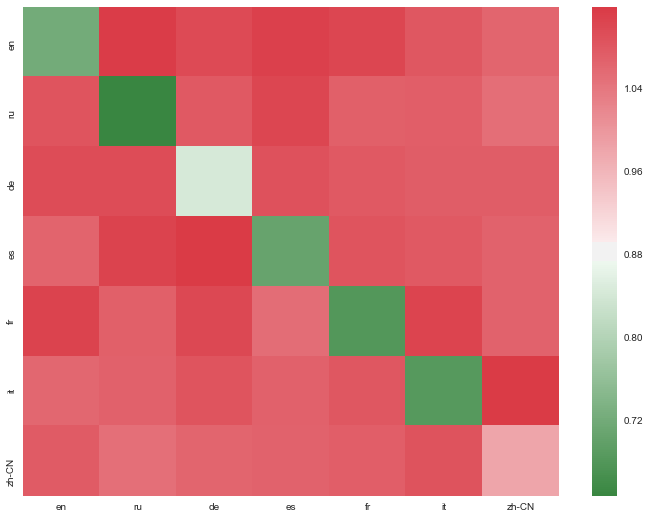

In [64]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

##############
#Set variables
T_MATRIX_DICT = full
DISPLAY_OPT = "cols"
STATS = ['min', 'max', 'mean', 'median', 'std', 'min_log', 'max_log', 'mean_log', 'median_log', 'std_log']
#['normality', 'min', 'max', 'mean', 'median', 'std', 'min_log', 'max_log', 'mean_log', 'median_log', 'std_log']
MATRIX_TYPES = ["T_matrix", "T_cov"]


###
heatmaps = plot_heatmaps(T_matrix_dict=T_MATRIX_DICT,
                         plotted_stats=STATS,
                         display_opt="cols",
                         matrix_types=MATRIX_TYPES,
                         low_c=10,
                         high_c=130,
                         sep_num=10,
                         figuresize=[12,9]
                        )

In [45]:
?sns.diverging_palette()

# Stage 3 (parts)
## Loads the Translation matrices 
## Performs the spectral analysis on them
## Returns dictionary with full analysis

In [4]:
# from T_matrix_spectral_analysis_tools import *

### Set args
T_MATRIX_DIR = "../data/l2=0_01_normality=0_000001/"

full = extract_T_matrix_dict(T_matrix_dir=T_MATRIX_DIR,
                             stats=['min','max','mean','median','std'],
                             calc_cov=True,
                             calc_inv=False,
                             calc_SVD=True,
                             log_spectrum=True,
                             normality=True,
                             verbose=0
                            )
full

{'de_de': {'T_cov': {'U_rotation': array([[-0.09725767,  0.07812188, -0.04310805, ...,  0.00803048,
            0.01615564,  0.00873843],
          [ 0.12419821, -0.12324405, -0.00184494, ..., -0.06318025,
            0.05744185,  0.0204795 ],
          [-0.11483201,  0.0356948 , -0.04234149, ..., -0.00407052,
            0.03232711,  0.02254314],
          ..., 
          [ 0.00402063,  0.12641018, -0.03712408, ...,  0.02436523,
            0.0186198 , -0.0253063 ],
          [ 0.01108975,  0.03792162,  0.06417358, ...,  0.05056623,
            0.04614681, -0.02298093],
          [ 0.12541965, -0.07486048, -0.00147911, ..., -0.01091719,
            0.01075292,  0.10362788]]),
   'V_rotation_transpose': array([[-0.09725767,  0.12419821, -0.11483201, ...,  0.00402063,
            0.01108975,  0.12541965],
          [ 0.07812188, -0.12324405,  0.0356948 , ...,  0.12641018,
            0.03792162, -0.07486048],
          [-0.04310805, -0.00184494, -0.04234149, ..., -0.03712408,
          

# TODO
    

- Write jsons to file at the end of my notebook or script
- integrate notebook with isomantics_statistical_analysis.py
    * https://github.com/mike-tamir/IsomanticsDev/blob/master/code/isomantics_statistical_analysis.py

- figure out where language order list lives
- add documentation to `heatmap_plotter` function

- Port my notebook functions in to ismtools

- figure out exporting to heatmaps and runing heatmap_plotter

# big TODO
## - Start making slides !!!!!!


In [ ]:
***** NOTE THE BELOW HAS BEEN MOVED TO DRIVER NOTEBOOK CURRENTLY IN CODE *******

## Overview
The Isomantics algorithm consists of the following stages:
### **(Stage 0)** Prepare vocabulary
* currently prepared languages:
    1. English
    2. Russian
    3. German
    4. French
    5. Italian
    6. Chinese 
    
### **(Stage 1)** Word embeddings.  Using `fasttext` or `word2vec` we embed the vocab for each of the languages
### **(Stage 2)** Train translation matrices:

* Training set:
    * For two given languages $Lg_1$ and $Lg_2$, we create a training set $\Omega_{(Lg_1,Lg_2)}$ as follows:
        1. For each $word_i$ in language 1, find the direct translation $\widehat{word_i}$ in language 2.
        2. Find vector embeddings $w_i\in Lg_1$ and $\widehat{w_i}\in Lg_2$ of $word_i$ and $\widehat{word_i}$ respectively.
        3. Add the pair $<w_i,\widehat{w_i}>$ to the training set $\Omega_{(Lg_1,Lg_2)}$
            * **Note** we found that training only for for only the the top 5-10k most popular terms in  $\Omega_{(Lg_1,Lg_2)}$ generates the best word-to-word translation results on out of sample test sets.
* Building the Cost function:
    * Loss function for the learning process:
        * $ Loss(T_{Lg_1,Lg_2})= ||Tw_i - \widehat{w_i}||^2_2 $
    * Regularization terms:
        * Over fitting Regularizer:
            * $Reg_{Frobenius}(T_{Lg_1,Lg_2}) = ||T_{Lg_1,Lg_2}||_2$
        * Normality Regularizer:
            * $Reg_{Normality}(T_{Lg_1,Lg_2}) = ||T_{Lg_1,Lg_2}^{T}T_{Lg_1,Lg_2} - T_{Lg_1,Lg_2}T_{Lg_1,Lg_2}^T||_2$
                * **Note** The Normality Regularizer is used to ensure that the resulting matrix is diagonalizable.


#### Full cost function:
$$ J(T_{Lg_1,Lg_2})= Loss(T_{Lg_1,Lg_2}) + \lambda_{1}Reg_{Frobenius}(T_{Lg_1,Lg_2}) + \lambda_{2}Reg_{Normality}(T_{Lg_1,Lg_2}) $$  

### **(Stage 3)** Translation Spectral Analysis:
* Factor the matrix $T_{Lg_1,Lg_2} = U\Sigma V^T$ where $U$ and $V$ are orthonormal (rotation) matrices and $\Sigma$ gives the eigenvalues of $T_{Lg_1,Lg_2}$  or the "*Translation spectrum*"
* Run a statistical analysis of the spectral values associated with each pair of languages.
    1. mean
    2. median
    3. max value
    4. min value
    5. standard deviation

* Compare the statistical spectral analysis across different language pairs.

# (Stage 0) Prepare vocabulary:

# TODO 
 * add details on where the vocab was downloaded from
 * point to where the data is in the repo
 * add instructions on where to call it in the code

# (Stages 1 and 2) 
1. Word embeddings. Using fasttext or word2vec we embed the vocab for each of the languages
2. Train translation matrices:

# TODO 
 * add details on where the vocab is located
 * point to where the embeddings are located
 * Test following code on embedding process:

In [1]:
# Import tools for running Spectral decomposition
import sys
sys.path.append("../")
import ismtools



Using TensorFlow backend.


In [ ]:
# TODO script this section and call the script from bash in this cell
    # add the -a for setting calculate_KNN = True
# TODO?? put manual list of translations into ismtools or another imported .py

#Set parameter on calculate KNN (need to change for -a sysarg)
calculate_KNN = False

languages = ['en','ru','de','es','fr','it', 'zh-CN']
for lang1 in languages:
    for lang2 in languages:
        translations.append(('fasttext_top',lang1, lang2))

for translation in translations:
    embedding, lg1, lg2 = translation
    # Vocab/Vectors/Dicts
    lg1_vocab, lg1_vectors, lg2_vocab, lg2_vectors = \
        pickle_rw((lg1 + '_' + embedding.split('_')[0] + '_vocab', 0),
                  (lg1 + '_' + embedding.split('_')[0] + '_vectors', 0),
                  (lg2 + '_' + embedding.split('_')[0] + '_vocab', 0),
                  (lg2 + '_' + embedding.split('_')[0] + '_vectors', 0),
                  write=False)
    lg1_dict = make_dict(lg1_vocab, lg1_vectors)
    lg2_dict = make_dict(lg2_vocab, lg2_vectors)

    print('Translation: '+lg1+'->'+lg2+'\n')

    # Train/Test Vocab/Vectors
    vocab_train, vocab_test = vocab_train_test(embedding, lg1, lg2, lg1_vocab)
    X_train, X_test, y_train, y_test = vectors_train_test(vocab_train,
                                                          vocab_test,lg1_dict,lg2_dict)
    
    # Fit tranlation matrix to training data
    model, history, T, tf, I, M, fro = translation_matrix(X_train, y_train)
    
    if calculate_KNN:
        results_df = translation_results(X_test, y_test, vocab_test, T,
                                     lg2_vectors, lg2_vocab)
        acc = T_norm_EDA(results_df)

"""
TODO create standardized dumping location for the translation matrix and its meta data.
- pickel dump based on the dir structure in the folders
"""        

# (Stage 3) Translation Spectral Analysis

# TODO 
 * 

In [42]:
# Set list of T_matrix full paths
T_matrix_dir = "./T_Matrices_examples/"
T_matrix_names = !ls $T_matrix_dir

T_matrix_full_paths = []
for T_matrix_name in T_matrix_names:
    T_matrix_loc = T_matrix_dir+T_matrix_name
    T_matrix_full_paths += [T_matrix_loc]

# Load T_matrix into memory
load_path = T_matrix_full_paths[2]
print(load_path)
file = open ("./T_Matrices_examples/T_matrix_de_es.pkl",'rb')
file.seek(0)
object_file = pickle.load(file)

"""
with open(r"./T_Matrices_examples/T_matrix_de_es.pkl", 'rb') as f:
    T_matrix = pickle.load(f)"""

./T_Matrices_examples/T_matrix_de_es.pkl


EOFError: 

In [ ]:
U,s,Vh = SVD(T)

s1 = log(s)


for stat in stats:
    svd[stat,translation[1],translation[2]] = stat_calc(stat, s, fro, acc)
    svd1[stat,translation[1],translation[2]] = stat_calc(stat, s1, fro, acc)


#Exporting DataFrames for SVD Heatmaps

s_df = make_df(languages,languages)
s1_df = make_df(languages,languages)


for stat in stats:
    for lang1 in languages:
        for lang2 in languages:
            s_df.set_value(lang1,lang2,svd[stat,lang1,lang2])
            s1_df.set_value(lang1,lang2,svd1[stat,lang1,lang2])

    s_df.to_csv('../HeatmapData/T/s_{}.csv'.format(stat),columns = languages)
    s1_df.to_csv('../HeatmapData/T/s1_{}.csv'.format(stat),columns = languages)



In [ ]:
if __name__ == '__main__':
    # Manually set list of translations (embedding, lg1, lg2)
    
    svds = ['s','s1']
    languages = ['en','ru','de','es','fr','it', 'zh-CN']
    stats = ['min','max','mean','median','std','fro','acc']
    
    translations=[]
    
    for lang1 in languages:
        for lang2 in languages:
            translations.append(('fasttext_top',lang1, lang2))
    
    svd = {}
    svd1 = {}
    
    for translation in translations:
        embedding, lg1, lg2 = translation
        # Vocab/Vectors/Dicts
        lg1_vocab, lg1_vectors, lg2_vocab, lg2_vectors = \
            pickle_rw((lg1 + '_' + embedding.split('_')[0] + '_vocab', 0),
                      (lg1 + '_' + embedding.split('_')[0] + '_vectors', 0),
                      (lg2 + '_' + embedding.split('_')[0] + '_vocab', 0),
                      (lg2 + '_' + embedding.split('_')[0] + '_vectors', 0),
                      write=False)
        lg1_dict = make_dict(lg1_vocab, lg1_vectors)
        lg2_dict = make_dict(lg2_vocab, lg2_vectors)

        print('Translation: '+lg1+'->'+lg2+'\n')

        # Train/Test Vocab/Vectors
        vocab_train, vocab_test = vocab_train_test(embedding, lg1, lg2, lg1_vocab)
        X_train, X_test, y_train, y_test = vectors_train_test(vocab_train,
                                                              vocab_test,lg1_dict,lg2_dict)
 
        
        # Fit tranlation matrix to training data
        model, history, T, tf,I, M, fro = translation_matrix(X_train, y_train)
        
        results_df = translation_results(X_test, y_test, vocab_test, T,
                                         lg2_vectors, lg2_vocab)
        acc = T_norm_EDA(results_df)
        
        U,s,Vh = SVD(T)
        
        s1 = log(s)
    
        
        for stat in stats:
            svd[stat,translation[1],translation[2]] = stat_calc(stat, s, fro, acc)
            svd1[stat,translation[1],translation[2]] = stat_calc(stat, s1, fro, acc)
            
        
    #Exporting DataFrames for SVD Heatmaps
    
    s_df = make_df(languages,languages)
    s1_df = make_df(languages,languages)
    

    for stat in stats:
        for lang1 in languages:
            for lang2 in languages:
                s_df.set_value(lang1,lang2,svd[stat,lang1,lang2])
                s1_df.set_value(lang1,lang2,svd1[stat,lang1,lang2])

        s_df.to_csv('../HeatmapData/T/s_{}.csv'.format(stat),columns = languages)
        s1_df.to_csv('../HeatmapData/T/s1_{}.csv'.format(stat),columns = languages)

    



# Translation Matrix Results  
## En to Ru Fasttext_Random  
- En Vocabulary Size = 1,259,685  
- En Embedding Length = 300  
- Ru Vocabulary Size = 944,211  
- Ru Embedding Length = 300  
- Train Size = 5,000  
- Test Size = 1,500  
- <b>Test Accuracy = 3.9%</b>  

#### Test L2 Norms  
- X_norm: L2 norms for En test vectors  
- y_norm: L2 norms for Ru test vectors  
- yhat_norm: L2 norms for X.dot(T) test vectors (T = translation matrix)  
- yhat_neighbor norm: L2 norms for nearest neighborto X.dot(T) in y test vectors  
![](../images/en_ru_fasttext_random_T_norm.png)  

#### Translation Matrix Isotropy  
- Isotropy = 32.3%  
![](../images/en_ru_fasttext_random_T_isotropy.png)  

## En to Ru Fasttext_Top  
- En Vocabulary Size = 1,259,685  
- En Embedding Length = 300  
- Ru Vocabulary Size = 944,211  
- Ru Embedding Length = 300  
- Train Size = 5,000  
- Test Size = 1,500  
- <b>Test Accuracy = 46.3%</b>  

#### Test L2 Norms  
- X_norm: L2 norms for En test vectors  
- y_norm: L2 norms for Ru test vectors  
- yhat_norm: L2 norms for X.dot(T) test vectors (T = translation matrix)  
- yhat_neighbor norm: L2 norms for nearest neighborto X.dot(T) in y test vectors  
![](../images/en_ru_fasttext_top_T_norm.png)  

#### Translation Matrix Isotropy  
- Isotropy = 38.2%  
![](../images/en_ru_fasttext_top_T_isotropy.png)  

## En to De Fasttext_Random  
- En Vocabulary Size = 1,259,685  
- En Embedding Length = 300  
- De Vocabulary Size = 1,137,616  
- De Embedding Length = 300  
- Train Size = 5,000  
- Test Size = 1,500  
- <b>Test Accuracy = 21.9%</b>  

#### Test L2 Norms  
- X_norm: L2 norms for En test vectors  
- y_norm: L2 norms for De test vectors  
- yhat_norm: L2 norms for X.dot(T) test vectors (T = translation matrix)  
- yhat_neighbor norm: L2 norms for nearest neighborto X.dot(T) in y test vectors  
![](../images/en_de_fasttext_random_T_norm.png)  

#### Translation Matrix Isotropy  
- Isotropy = 35.6%  
![](../images/en_de_fasttext_random_T_isotropy.png)  

## En to De Fasttext_Top  
- En Vocabulary Size = 1,259,685  
- En Embedding Length = 300  
- De Vocabulary Size = 1,137,616  
- De Embedding Length = 300  
- Train Size = 5,000  
- Test Size = 1,500  
- <b>Test Accuracy = 63.6%</b>  

#### Test L2 Norms  
- X_norm: L2 norms for En test vectors  
- y_norm: L2 norms for De test vectors  
- yhat_norm: L2 norms for X.dot(T) test vectors (T = translation matrix)  
- yhat_neighbor norm: L2 norms for nearest neighborto X.dot(T) in y test vectors  
![](../images/en_de_fasttext_top_T_norm.png)  

#### Translation Matrix Isotropy  
- Isotropy = 43.4%  
![](../images/en_de_fasttext_top_T_isotropy.png)  

## En to It Zeroshot  
- En Vocabulary Size = 200,000  
- En Embedding Length = 300  
- It Vocabulary Size = 200,000  
- It Embedding Length = 300  
- Train Size = 5,000  
- Test Size = 1,869  
- <b>Test Accuracy = 27.9%</b>  

#### Test L2 Norms  
- X_norm: L2 norms for En test vectors  
- y_norm: L2 norms for It test vectors  
- yhat_norm: L2 norms for X.dot(T) test vectors (T = translation matrix)  
- yhat_neighbor norm: L2 norms for nearest neighborto X.dot(T) in y test vectors  
![](../images/en_it_zeroshot_T_norm.png)  

#### Translation Matrix Isotropy  
- Isotropy = 46.6%  
![](../images/en_it_zeroshot_T_isotropy.png)  

